In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn import linear_model
from sklearn.feature_extraction.image import PatchExtractor as PE



Populating the interactive namespace from numpy and matplotlib


In [ ]:
#random variation of parameters
def randpar(par,var):
    '''This function adds gaussian noise to parameters stored in a dictionary. 
    var is the std of the gaussian distribution (1 = 100% of the not noisy value).'''
    flag = 0
    while flag == 0:
        temp = cp.deepcopy(par)
        for key in par.keys():
            temp[key]=par[key]*(1+var*plb.randn())
            #if temp[key] < 0:
            #    flag = 0
            #    break
            #else:
                #flag =1
            if temp[key] < 0:
                temp[key] = 0
        flag = 1            
    return temp  

## 3D Lorenz Model

In [ ]:
#3D Lorenz
def Lder(x,t,p):
    der0 = p['s']*(x[1] - x[0])
    der1 = x[0]*(p['r']-x[2]) - x[1]
    der2 = x[0]*x[1] - p['b']*x[2]
    return [der0,der1,der2]

Lpar= dict(s= 10., b =8./3, r = 28)

In [ ]:
# to find initial condition box, make sure fixed points are included
print("fp1",[-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1])
print("fp2",[sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1])

fp1 [-8.4852813742385695] [-8.4852813742385695] [27]
fp2 [8.4852813742385695] [8.4852813742385695] [27]


# Function to return trajectories

In [ ]:
# for fixed Delta t solve 300 trajectories
def traj_solve(N,dt,mod,mod_par,var):
    t0 = 0
    tend = 1
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),3),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        yinit = (plb.rand(3)-[0.5,0.5,0])*[40,60,50]
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time    

# for fixed Delta t solve 
def traj_solve_mod(N,dt,tend,mod,mod_par,var):
    t0 = 0
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),3),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        yinit = (plb.rand(3)-[0.5,0.5,0])*[40,60,50]
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time 

## Example

In [ ]:
N = 300
traj,time = traj_solve(N,0.01,Lder,Lpar,0.0)

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


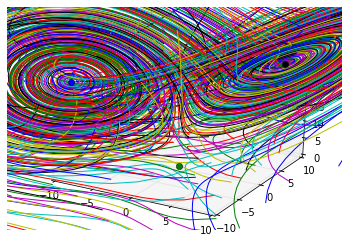

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(N):
    ax.plot(traj[i,:,0], traj[i,:,1], traj[i,:,2])
#fixed point 1    
ax.plot([sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'o')    
#fixed point 2
ax.plot([-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'o')    
#fixed point 3
ax.plot([0],[0],[0],'o')   
ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10,10)
ax.set_zlim3d(0,30)
ax.legend()
plt.show()

# trajectories to samples of f

In [ ]:
def traj_der(traj,time):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt
                
    return trajder           

In [ ]:
time[1]-time[0]

0.010101010101010102

## Example

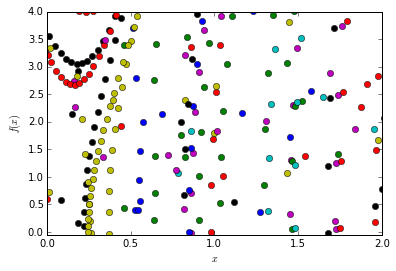

In [ ]:
trajder = traj_der(traj,time)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,2))
    ylim((-0.05,4))

## Scale and discretize measurments to fit on a 32x32x32 grid

In [ ]:
#convert discrete index to x1,x2 position in the model

#continuous scaling
#0 -> -21
#31 -> 21
def ind_to_x(i):
    return i*42./31. -21
#0 -> -29
#31 -> 29
def ind_to_y(i):
    return i*58/31. -29

#0 -> 0
#31 -> 30
def ind_to_z(i):
    return i*52/31. -2.


In [ ]:
ind_to_z(31)

50.0

In [ ]:
# convert x position to discrete index

#-21 -> 0
#21 -> 31
def x_to_ind(x):
    ind = x*31./42. +31./2.
    if isfinite(ind):
        return int(round(ind))
    else:
        return np.nan 
#-29 -> 0
#29 -> 31
def y_to_ind(x):
    ind = x*31./58. +31./2.
    if isfinite(ind):
        return int(round(ind))
    else:
        return np.nan
#0 -> 0
#30 -> 31
def z_to_ind(x):
    ind = x*31./52.+31./26.
    if isfinite(ind):
        return int(round(ind))
    else:
        return np.nan

In [ ]:
z_to_ind(ind_to_z(31))

31

In [ ]:
def traj_to_f_meas(traj,trajder,jj):
    N,Nt,Nvar = np.shape(traj)
    f_meas = np.full((N,32,32,32),-100.)
    for k in range(N):
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = y_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            ind2 = z_to_ind((traj[k,i+1,2]+traj[k,i,2])/2.)
            if  (ind0 < 32) and (ind1 < 32) and (ind2 < 32):
                if (ind0 >= 0) and (ind1 >= 0) and (ind2 >= 0):
                    f_meas[k,ind0,ind1,ind2] = trajder[k,i,jj]
    return f_meas  

def traj_to_f_m(traj,trajder,Ntraj,jj):
    N,Nt,Nvar = np.shape(traj)
    f_m = np.full((32,32,32),-100.)
    touched = np.full((32,32,32),0.)
    s = sorted(permutation(N)[:Ntraj])
    for k in s:
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = y_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            ind2 = z_to_ind((traj[k,i+1,2]+traj[k,i,2])/2.)
            if  (ind0 < 32) and (ind1 < 32) and (ind2 < 32):
                if (ind0 >= 0) and (ind1 >= 0) and (ind2 >= 0):
                    if touched[ind0,ind1,ind2] == 0.:
                        f_m[ind0,ind1,ind2] = trajder[k,i,jj]
                    else:    
                        f_m[ind0,ind1,ind2] += trajder[k,i,jj]
                        
                    touched[ind0,ind1,ind2] +=1.
                    
    for i in range(32):
        for j in range(32):
            for k in range(32):
                if touched[i,j,k]!=0.:
                    f_m[i,j,k]/=float(touched[i,j,k])
    return f_m

# Sparsely reconstruct under-sampled data in basis

In [ ]:
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = True):
    clf = linear_model.Lasso(alpha=0.000001, copy_X=True, fit_intercept=False, max_iter=3000, tol=0.00000000001)

    #create array for reconstructed data
    recdata = np.full(data.shape,0.)
    
    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
            clf.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,clf.coef_)
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                print("not enough data!\n")
                #print(i)
                continue
            #elif len(rm) == ps1*ps2:
                #recdata[i,:] = data[i,:]
                #continue
        clf.fit(basis[:,rm].T, data[i,rm])
        #(3) reconstruct patch from fit coefficients
        recdata[i,:] = np.dot(basis.T,clf.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = True):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    print(patch_size)
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    print("shape of data",data.shape)
    datarec = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = rec_from_patches_2d(datarec, imsize)
    return rec

In [ ]:
def rec_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    from itertools import product as pd
    
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    touched = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, pd(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p
        touched[i:i + p_h, j:j + p_w] +=1

    #story checks out until here, I think    
    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            
            #img[i, j] /= float(min(i + 1, p_h, i_h - i) *
             #                  min(j + 1, p_w, i_w - j))
            img[i,j]/=float(touched[i,j])    
    return img

# learn basis from data

In [ ]:
#number of trajectories to include
def f_prep(N,NTraj,f_meas,b_size):
    #start with a random basis
    r_basis = np.random.rand(100,b_size)
    _,l1,l2 = f_meas.shape
    #sample randomly from all trajectories
    s = sorted(permutation(N)[:NTraj])
    f_m = np.full((l1,l2),-100.)
    #for fixed (x1,x2) average over all trajectory measurements (only those values that are not -100)
    for i in range(l1):
        for j in range(l2):
            col = [f_meas[k,i,j] for k in s if f_meas[k,i,j]!= -100.]
            if col == []:
                f_m[i,j] = -100.
            else:
                f_m[i,j] = np.mean(col)
    return f_m,r_basis

In [ ]:
# learn basis, return reconstruction and basis
def basis_and_rec(f_m,init_basis):
    print("starting rec...")
    b_size = init_basis.shape
    b_s = int(sqrt(b_size[1]))
    #print(b_size)
    #reconstruct sparsely in random basis
    print("first rec in random basis")
    #rec = image_rec(f_m,init_basis,1,b_s,b_s,real_data = True)
    rec = f_m
    rec[f_m==-100.] = np.random.rand()
    tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=1, n_iter=1000 )
    # resize to basis size
    datarec = extract_patches_2d(rec,(b_s,b_s))
    datarec = datarec.reshape(datarec.shape[0], -1)
    print("learning basis")
    V = tempdic.fit(datarec).components_
    print("second rec, in learned basis")
    rec = image_rec(f_m,V,1,b_s,b_s,real_data = True)
    
    return V,rec

# measure Error

In [ ]:
def norm_1(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)
    if np.linalg.norm(r)!=0.:
        norm = 1. - abs(np.dot(d,r))/np.linalg.norm(d)/np.linalg.norm(r)
    else:
        norm = 1. 
    return norm

def norm_2(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)
    return norm

def norm_3(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)/np.linalg.norm(d)
    return norm

(-2, 50)

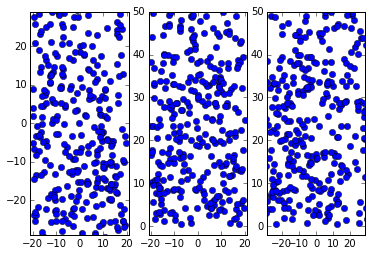

In [ ]:
subplot(1,3,1)
plot(traj[:,0,0],traj[:,0,1],'o')
xlim(-21,21)
ylim(-29,29)
subplot(1,3,2)
plot(traj[:,0,0],traj[:,0,2],'o')
xlim(-21,21)
ylim(-2,50)
subplot(1,3,3)
plot(traj[:,0,1],traj[:,0,2],'o')
xlim(-29,29)
ylim(-2,50)

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


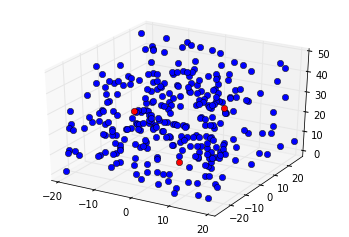

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(N):
    ax.plot([traj[i,0,0]], [traj[i,0,1]], [traj[i,0,2]],'bo')
#fixed point 1    
ax.plot([sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'ro')    
#fixed point 2
ax.plot([-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'ro')    
#fixed point 3
ax.plot([0],[0],[0],'ro')   
ax.set_xlim3d(-21, 21)
ax.set_ylim3d(-29,29)
ax.set_zlim3d(-2,50)
ax.legend()
plt.show()

# Running Script

In [ ]:
#create reference function f_ref
f_ref = np.full((3,32,32,32),0.)
for i in range(32):
    for j in range(32):
        for k in range(32):
            f_ref[0,i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[0]
            f_ref[1,i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[1]
            f_ref[2,i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[2]
f_ref = f_ref.reshape((3,-1,32),order = 'C')      

In [ ]:
# generate trajectories
N = 10000
traj,time = traj_solve(N,0.01,Lder,Lpar,0.0)        
#generate derivatives
trajder = traj_der(traj,time)

#rescale to sample f
f_meas0 = reshape(traj_to_f_meas(traj,trajder,0),(N,-1,32),order = 'C')
print("done0")
f_meas1 = reshape(traj_to_f_meas(traj,trajder,1),(N,-1,32),order = 'C')
print("done1")
f_meas2 = reshape(traj_to_f_meas(traj,trajder,2),(N,-1,32),order = 'C')
print("done2")

from time import time as Ttime
tbeg = Ttime()
Ntraj = 1000
b_size = 20*20
f_m0,r_basis = f_prep(N,Ntraj,f_meas0,b_size)
print("done1")
print(Ttime()-tbeg)
f_m1,r_basis = f_prep(N,Ntraj,f_meas1,b_size)
print("done2")
print(Ttime()-tbeg)
f_m2,r_basis = f_prep(N,Ntraj,f_meas2,b_size)
print("done3")
print(Ttime()-tbeg)

In [ ]:
from time import time as Ttime
tbeg = Ttime()
f_m0 = reshape(traj_to_f_m(traj,trajder,N,0),(-1,32),order = 'C')
print("done0")
print(Ttime()-tbeg)
f_m1 = reshape(traj_to_f_m(traj,trajder,N,1),(-1,32),order = 'C')
print("done1")
print(Ttime()-tbeg)
f_m2 = reshape(traj_to_f_m(traj,trajder,N,2),(-1,32),order = 'C')
print("done2")
print(Ttime()-tbeg)

done0
19.182703018188477
done1
37.895647048950195
done2
57.26208710670471


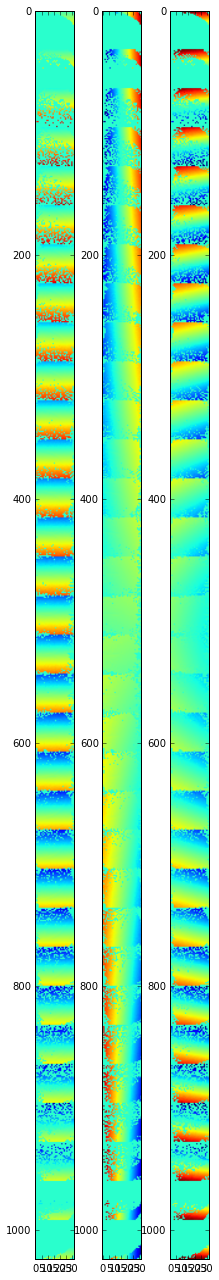

In [ ]:
#f_meas = traj_to_f_meas(traj,trajder,0)
vmin = np.min(f_ref[0])
vmax = np.max(f_ref[0])
figure(figsize = (3,20))
subplot(1,3,1)
imshow(f_m0,vmin=vmin,vmax=vmax)
subplot(1,3,2)
imshow(f_m1,vmin=vmin,vmax=vmax)
subplot(1,3,3)
imshow(f_m2,vmin=vmin,vmax=vmax)
tight_layout()

In [ ]:
f_m0.shape

(1024, 32)

# Key to good reconstruction was to get patches from each section and not from the whole unraveld 3D function. The reconstruction will get even better with each section reconstruced separately

In [ ]:
ps1 = 25
ps2 = 25
pe = PE((ps1,ps2))
l=[]
for i in range(1024//32):
    l.append(eval('f_m0['+str(i*32)+':'+str(i*32+32)+',:32]'))
for i in range(1024//32):
    l.append(eval('f_m1['+str(i*32)+':'+str(i*32+32)+',:32]'))
for i in range(1024//32):
    l.append(eval('f_m2['+str(i*32)+':'+str(i*32+32)+',:32]'))    
patches = reshape(pe.transform(array(l)),(-1,ps1*ps2),order='C')
for i in range(patches.shape[0]):
    m = [np.random.rand() for j in range(len(patches[i,:])) if patches[i,j]==-100.]
    patches[i][patches[i]==-100.]= m

In [ ]:
# 3D good rec: Ntraj = 10000, dt = 0.01, b_size = 625

In [ ]:
tbeg= Ttime()
tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.1, n_iter=10000 )
V = tempdic.fit(patches).components_
print(Ttime()-tbeg)

346.66191601753235


//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


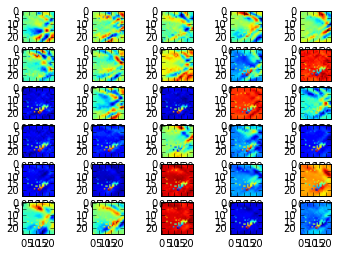

In [ ]:
for i,comp in enumerate(V):
    subplot(6,5,i+1)
    imshow(reshape(comp,(ps1,ps2)))

In [ ]:
rec0 = np.full((32,32,32),0)
for j,f in enumerate(l[:32]):
    t0=Ttime()
    rec0[j,:,:] = image_rec(f,V,1,ps1,ps2)
print(Ttime()-t0)

rec1 = np.full((32,32,32),0)
for j,f in enumerate(l[32:64]):
    t0=Ttime()
    rec1[j,:,:] = image_rec(f,V,1,ps1,ps2)
print(Ttime()-t0)

rec2 = np.full((32,32,32),0)
for j,f in enumerate(l[64:]):
    t0=Ttime()
    rec2[j,:,:] = image_rec(f,V,1,ps1,ps2)
print(Ttime()-t0)

#np.savez("3drec_g",rec0,rec1,rec2)
#np.savez("3dmeas_g",f_m0,f_m1,f_m2)

(25, 25)
shape of data (64, 625)
not enough data!

not enough data!

not enough data!

(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data (64, 625)
(25, 25)
shape of data

//anaconda/envs/py3/lib/python3.4/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full((32, 32, 32), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [ ]:
ls 3d*


3d_err_dt_Ntraj.txt        3d_err_vs_dt.pdf
3d_err_dt_Ntraj2.txt       3d_example_rec_b.pdf
3d_err_dt_Ntraj3.txt       3d_example_rec_g.pdf
3d_err_dt_Ntraj4.txt       3d_rec_phasespace_g.pdf
3d_err_dt_Ntraj_0.001.txt  3d_rec_projections_g.pdf
3d_err_dt_Ntraj_0.005.txt  3d_traj.pdf
3d_err_dt_Ntraj_0.01.txt   3dmeas_b.npz
3d_err_dt_Ntraj_0.05.txt   3dmeas_g.npz
3d_err_dt_Ntraj_0.1.txt    3drec.txt.npz
3d_err_dt_Ntraj_0.5.txt    3drec_b.npz
3d_err_vs_Ntraj.pdf        3drec_g.npz


In [ ]:
#np.savez("3drec_b",rec0,rec1,rec2)
#np.savez("3dmeas_b",f_m0,f_m1,f_m2)
#np.savez("3drec_g",rec0,rec1,rec2)
#np.savez("3dmeas_g",f_m0,f_m1,f_m2)
recfile = np.load("3drec_g.npz")
rfile = np.load("3dmeas_g.npz")
Rec0 = recfile['arr_0']
Rec1 = recfile['arr_1']
Rec2 = recfile['arr_2']
f_M0 = rfile['arr_0']
f_M1 = rfile['arr_1']
f_M2 = rfile['arr_2']

In [ ]:
array([norm_1(Ref0,Rec0),norm_1(Ref1,Rec1),norm_1(Ref2,Rec2)])

array([ 0.08481367,  0.27146229,  0.12363287])

In [ ]:
#R0 = reshape(Rec0,(32,32,32),order= "C")
#R1 = reshape(Rec1,(32,32,32),order= "C")
#R2 = reshape(Rec2,(32,32,32),order= "C")
Ref0 = reshape(f_ref[0],(32,32,32),order= "C")
Ref1 = reshape(f_ref[1],(32,32,32),order= "C")
Ref2 = reshape(f_ref[2],(32,32,32),order= "C")
FM0 = reshape(f_M0,(32,32,32),order='C')
FM1 = reshape(f_M1,(32,32,32),order='C')
FM2 = reshape(f_M2,(32,32,32),order='C')

f_m0 = np.full(f_M0.shape,np.nan)
f_m0[f_M0>-100]=f_M0[f_M0>-100]
f_m1 = np.full(f_M1.shape,np.nan)
f_m1[f_M1>-100]=f_M1[f_M1>-100]
f_m2 = np.full(f_M1.shape,np.nan)
f_m2[f_M1>-100]=f_M1[f_M1>-100]

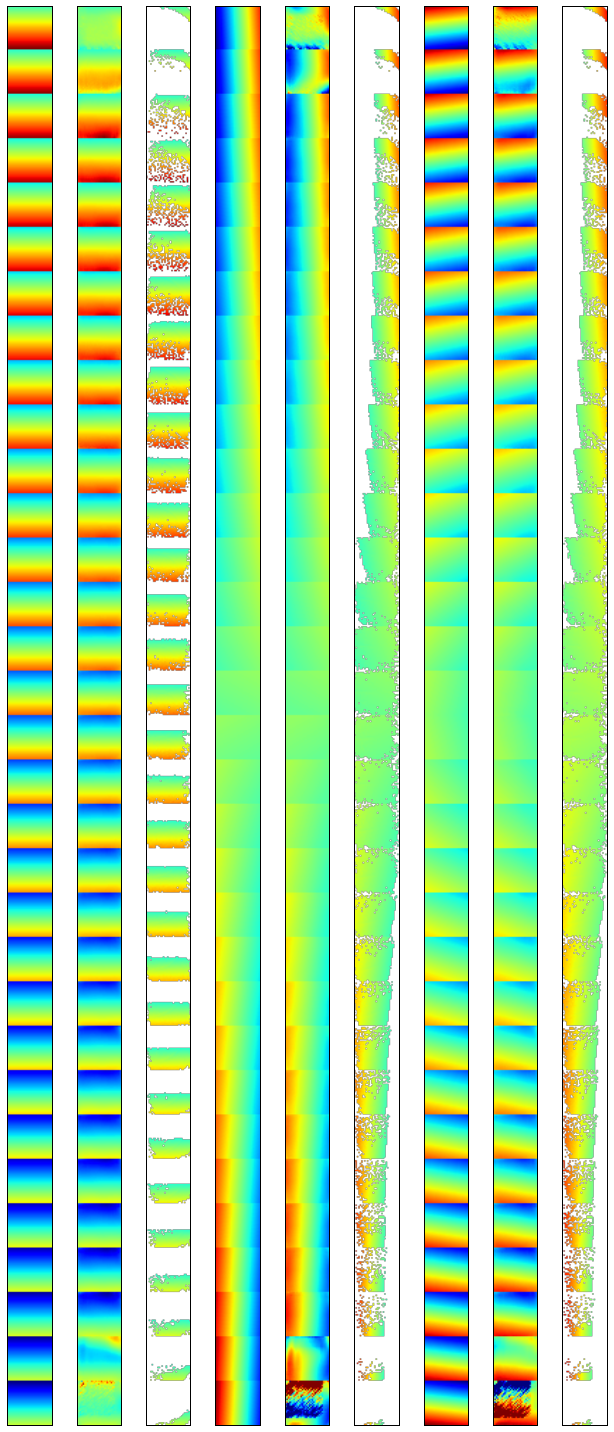

In [ ]:
vmin0 = np.min(f_ref[0])
vmax0 = np.max(f_ref[0])
vmin1 = np.min(f_ref[1])
vmax1 = np.max(f_ref[1])
vmin2 = np.min(f_ref[2])
vmax2 = np.max(f_ref[2])
figure(figsize = (9,20))
subplot(1,9,3)
imshow(f_m0,vmin=vmin0,vmax=vmax0)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,1)
imshow(f_ref[0],vmin=vmin0,vmax=vmax0)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,2)
imshow(reshape(Rec0,f_M0.shape,order='C'),vmin=vmin0,vmax=vmax0)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,6)
imshow(f_m1,vmin=vmin1,vmax=vmax1)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,4)
imshow(f_ref[1],vmin=vmin1,vmax=vmax1)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,5)
imshow(reshape(Rec1,f_M0.shape,order='C'),vmin=vmin1,vmax=vmax1)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,9)
imshow(f_m2,vmin=vmin2,vmax=vmax2)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,7)
imshow(f_ref[2],vmin=vmin2,vmax=vmax2)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
subplot(1,9,8)
imshow(reshape(Rec2,f_M0.shape,order='C'),vmin=vmin2,vmax=vmax2)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')
tight_layout()
#savefig("ofd/3d_example_rec_g_temp.pdf")

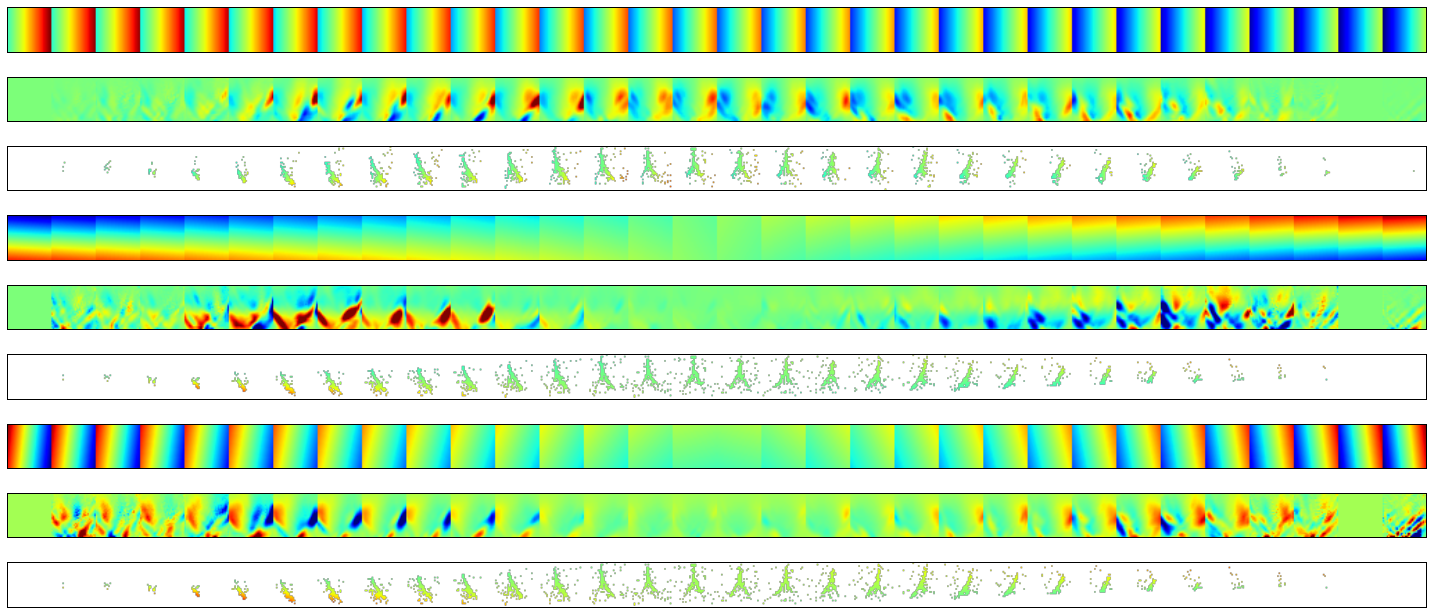

In [ ]:
vmin0 = np.min(f_ref[0])
vmax0 = np.max(f_ref[0])
vmin1 = np.min(f_ref[1])
vmax1 = np.max(f_ref[1])
vmin2 = np.min(f_ref[2])
vmax2 = np.max(f_ref[2])
#colorbar parameters and axes
sh = 0.8
a = 5
#cbaxes = f.add_axes([0.8, 0.1, 0.03, 0.8])

f = plt.figure(figsize = (20,9))
subplot(9,1,3)
imshow(f_m0.T,vmin=vmin0,vmax=vmax0)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,1)
imshow(f_ref[0].T,vmin=vmin0,vmax=vmax0)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,2)
imshow(reshape(Rec0,FM_0.shape,order='C').T,vmin=vmin0,vmax=vmax0)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,6)
imshow(f_m1.T,vmin=vmin1,vmax=vmax1)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,4)
imshow(f_ref[1].T,vmin=vmin1,vmax=vmax1)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,5)
imshow(reshape(Rec1,FM_0.shape,order='C').T,vmin=vmin1,vmax=vmax1)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,9)
imshow(f_m2.T,vmin=vmin2,vmax=vmax2)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,7)
imshow(f_ref[2].T,vmin=vmin2,vmax=vmax2)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

subplot(9,1,8)
imshow(reshape(Rec2,FM_0.shape,order='C').T,vmin=vmin2,vmax=vmax2)
tick_params(axis='both',which='both',top = 'off',bottom='off',right='off', left='off', labelleft='off', labelbottom='off')

tight_layout()
#savefig("ofd/3d_example_rec_g_temp.pdf")


# Reshape reconstruction to 3d function

In [ ]:
f_r = np.full((3,32,32,32),0.)
for i in range(32):
    for j in range(32):
        for k in range(32):
            f_r[0,i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[0]
            f_r[1,i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[1]
            f_r[2,i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[2]

In [ ]:
(vmin0,vmax0,vmin1,vmax1,vmin2,vmax2)

(-500.0, 500.0, -659.0, 659.0, -742.33333333333326, 614.33333333333337)

In [ ]:
#test ODE
def Lrecder(x,t):
    i = x_to_ind(x[0])
    j = y_to_ind(x[1])
    k = z_to_ind(x[2])
    if i >= 0 and i < 32 and j >= 0 and j < 32 and k >= 0 and k < 32:
        der0 = Rec0[i,j,k]
    else:
        #print('here')
        der0 = 0.
    if i >= 0 and i < 32 and j >= 0 and j < 32 and k >= 0 and k < 32:   
        der1 = Rec1[i,j,k]
    else:
        #print('here')
        der1 = 0.
    if i >= 0 and i < 32 and j >= 0 and j < 32 and k >= 0 and k < 32:   
        der2 = Rec2[i,j,k]
    else:
        #print('here')
        der2 = 0.
    return array([der0,der1,der2])

def Lmeasder(x,t):
    i = x_to_ind(x[0])
    j = y_to_ind(x[1])
    k = z_to_ind(x[2])    
    if i >= 0 and i < 32:
        der0 = FM0[i,j,k]
    else:
        der0 = 0.
    if j >= 0 and j < 32:   
        der1 = FM1[i,j,k]
    else:
        der1 = 0.
    if k >= 0 and k < 32:   
        der2 = FM2[i,j,k]
    else:
        der2 = 0.
    return array([der0,der1,der2])

def Lrefder(x,t):
    i = x_to_ind(x[0])
    j = y_to_ind(x[1])
    k = z_to_ind(x[2])    
    
    if i >= 0 and i < 32 and j >= 0 and j < 32 and k >= 0 and k < 32:
        der0 = f_r[0,i,j,k]
    else:
        der0 = 0.
    if i >= 0 and i < 32 and j >= 0 and j < 32 and k >= 0 and k < 32:   
        der1 = f_r[1,i,j,k]
    else:
        der1 = 0.
    if i >= 0 and i < 32 and j >= 0 and j < 32 and k >= 0 and k < 32:   
        der2 = f_r[2,i,j,k]
    else:
        der2 = 0.    
    return array([der0,der1,der2])

In [ ]:
# find trajectories that stay in between (0,2)x(0,2)
traj,time = traj_solve_mod(10000,0.01,1.,Lder,Lpar,0.0)

In [ ]:
l = []
for i in range(10000):
    ind00 = x_to_ind(np.min(traj[i,:,0]))
    ind01 = x_to_ind(np.max(traj[i,:,0]))
    ind10 = y_to_ind(np.min(traj[i,:,1]))
    ind11 = y_to_ind(np.max(traj[i,:,1]))
    ind20 = z_to_ind(np.min(traj[i,:,2]))
    ind21 = z_to_ind(np.max(traj[i,:,2]))
    if ind00 > 5 and ind01 < 25 and ind10 > 5 and ind11 <25 and ind20 < 25 and ind21 > 5 :
        l.append(i)

print(len(l))    

1048


In [ ]:
print(np.min(traj[:,:,0]),np.max(traj[:,:,0]))
print(np.min(traj[:,:,1]),np.max(traj[:,:,1]))
print(np.min(traj[:,:,2]),np.max(traj[:,:,2]))

-26.5516091406 26.4588994173
-38.784876592 38.9847890215
-9.84276239472 59.9584698319


In [ ]:
# solve in original and recontructed function
t0 = 0
tend = 3.
dt = 0.01
Nt = (tend-t0)/float(dt)
time = np.linspace(t0,tend,Nt)
n = 10
trajor = np.full((n,len(time),3),np.nan)
trajrec = np.full((n,len(time),3),np.nan)
trajref = np.full((n,len(time),3),np.nan)
var = 0.

for i in range(10):
    print(i)
    yinit = traj[l[i],0,:]
    trajor[i,:,:] = odeint(Lder,yinit,time,args = (Lpar,), rtol=1e-10, atol=1e-12)
    trajrec[i,:,:] = odeint(Lrecder,yinit,time,printmessg=True, rtol=1e-10, atol=1e-16)
    #trajref[i,:,:] = odeint(Lrefder,yinit,time, rtol=1e-10, atol=1e-12)

0
1
2
3
4
5
6
7
8
9


//anaconda/envs/py3/lib/python3.4/site-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


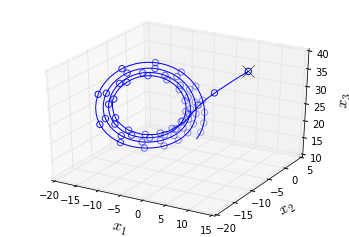

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
tend = 300
lk = [9]
c = ['b','r']
for j,i in enumerate(lk):
    #ax.plot(trajor[i,:tend,0][::4], trajor[i,:tend,1][::4], trajor[i,:tend,2][::4],'o')
    ax.scatter(trajor[i,:tend,0][::5], trajor[i,:tend,1][::5],trajor[i,:tend,2][::5], s=40, facecolors='none',edgecolors =c[j] )
for j,i in enumerate(lk):
    ax.plot(trajrec[i,:tend,0], trajrec[i,:tend,1], trajrec[i,:tend,2],c[j]+'-')
    ax.plot([trajor[i,0,0]], [trajor[i,0,1]], [trajor[i,0,2]],'kx',markersize=12)    
#fixed point 1    
#ax.plot([sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'o')    
#fixed point 2
#ax.plot([-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'o')    
#fixed point 3
#ax.plot([0],[0],[0],'o')   
#ax.set_xlim3d(-21, 21)
#ax.set_ylim3d(-29,29)
#ax.set_zlim3d(-2,50)
ax.set_xlabel('\n $x_1$',size='15')
ax.set_ylabel('\n $x_2$',size='15')
ax.set_zlabel('\n $x_3$',size='15')
ax.legend()
plt.show()
#tight_layout()
#fig.savefig("ofd/3d_rec_phasespace_g.pdf") 

time=np.linspace(0,10,num=1000000)
ytest = np.full((len(time),3),0.0)

ytest[0,:] = trajrec[2,0,:]
for i in range(1,len(time)):
    ytest[i,:] = ytest[i-1,:]+(time[1]-time[0])*Lrecder(ytest[i-1,:],1)

te = 10000
plot(ytest[:te*100,0],ytest[:te*100,1],'--')
plot(trajrec[2,:te,0],trajrec[2,:te,1],)

## Lyapunov Exponents
* solve ODE with two close initial conditions $d_0$ apart
* at each step measure divergence $\ln(d_0/d_1)$

In [ ]:
t0 = 0
tend = 2.
dt = 0.001
Nt = (tend-t0)/float(dt)
time = np.linspace(t0,tend,Nt)
n = 1000
t_rec0 = np.full((n,len(time),3),np.nan)
t_rec1 = np.full((n,len(time),3),np.nan)
var = 0.

for i in range(n):
    print(i)
    yinit0 = traj[l[i],0,:]
    yinit1 = traj[l[i],0,:]+[1e-8,0.,0.0]
    t_rec0[i,:,:] = odeint(Lrecder,yinit0,time, printmessg=True,rtol=1e-10, atol=1e-16)
    t_rec1[i,:,:] = odeint(Lrecder,yinit1,time,printmessg=True, rtol=1e-10, atol=1e-16)
    #trajref[i,:,:] = odeint(Lrefder,yinit,time, rtol=1e-10, atol=1e-12)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21

//anaconda/envs/py3/lib/python3.4/site-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/scipy/integrate/odepack.py:159: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)



22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
2

In [ ]:
Ll = []
Ll_temp = []
for j in range(n):
    #if trajectory contained in box j index of good trajectories
    ind00 = x_to_ind(np.min(t_rec0[j,:,0]))
    ind01 = x_to_ind(np.max(t_rec0[j,:,0]))
    ind10 = y_to_ind(np.min(t_rec0[j,:,1]))
    ind11 = y_to_ind(np.max(t_rec0[j,:,1]))
    ind20 = z_to_ind(np.min(t_rec0[j,:,2]))
    ind21 = z_to_ind(np.max(t_rec0[j,:,2]))
    if ind00 > 1 and ind01 < 32 and ind10 > 1 and ind11 < 32 and ind20 < 32 and ind21 > 1 :
        Ll_temp.append(j)

for j in Ll_temp:
    #if trajectory contained in box j index of good trajectories
    ind00 = x_to_ind(np.min(t_rec1[j,:,0]))
    ind01 = x_to_ind(np.max(t_rec1[j,:,0]))
    ind10 = y_to_ind(np.min(t_rec1[j,:,1]))
    ind11 = y_to_ind(np.max(t_rec1[j,:,1]))
    ind20 = z_to_ind(np.min(t_rec1[j,:,2]))
    ind21 = z_to_ind(np.max(t_rec1[j,:,2]))
    if ind00 > 1 and ind01 < 32 and ind10 > 1 and ind11 <32 and ind20 < 32 and ind21 > 1 :
        Ll.append(j)

In [ ]:
len(Ll)

834

In [ ]:
traj.shape

(10000, 100, 3)

In [ ]:
t0 = 0
tend = 10.
dt = 0.001
Nt = (tend-t0)/float(dt)
time = np.linspace(t0,tend,Nt)
n = 1000
t_rec0 = np.full((n,len(time),3),np.nan)
t_rec1 = np.full((n,len(time),3),np.nan)
for j in Ll:
    t_rec0[j,0,:]= traj[j,0,:]
    t_rec1[j,0,:]= traj[j,0,:]+[0.0001,0.,0.0]
    for i in range(1,len(time)):
        t_rec0[j,i,:] = t_rec0[j,i-1,:]+(time[1]-time[0])*Lrecder(t_rec0[j,i-1,:],1)
        t_rec1[j,i,:] = t_rec1[j,i-1,:]+(time[1]-time[0])*Lrecder(t_rec1[j,i-1,:],1)

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


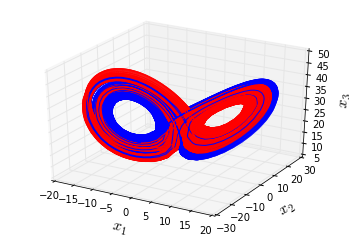

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
tend = len(time)
lk = Ll[:2]
c = ['b','r','g','k','y','r','b','r']
for j,i in enumerate(lk):
    #ax.plot(trajor[i,:tend,0][::4], trajor[i,:tend,1][::4], trajor[i,:tend,2][::4],'o')
    ax.scatter(t_rec0[i,:tend,0], t_rec0[i,:tend,1], t_rec0[i,:tend,2], s=40, facecolors='none',edgecolors =c[j] )
for j,i in enumerate(lk):
    ax.plot(t_rec1[i,:tend,0], t_rec1[i,:tend,1], t_rec1[i,:tend,2],c[j]+'-')
    #ax.plot([trajor[i,0,0]], [trajor[i,0,1]], [trajor[i,0,2]],'kx',markersize=12)    
#fixed point 1    
#ax.plot([sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'o')    
#fixed point 2
#ax.plot([-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'o')    
#fixed point 3
#ax.plot([0],[0],[0],'o')   
#ax.set_xlim3d(-21, 21)
#ax.set_ylim3d(-29,29)
#ax.set_zlim3d(-2,50)
ax.set_xlabel('\n $x_1$',size='15')
ax.set_ylabel('\n $x_2$',size='15')
ax.set_zlabel('\n $x_3$',size='15')
ax.legend()
plt.show()

In [ ]:
LE = [] 
LE_temp = []
tsep = []
ts = []
#for j in Ll:
for j in Ll:
    #LE_temp = [] 
    d0 = sqrt((t_rec0[j,0,0]-t_rec1[j,0,0])**2+(t_rec0[j,0,1]-t_rec1[j,0,1])**2+(t_rec0[j,0,2]-t_rec1[j,0,2])**2)
    dt = time[1]-time[0]
    s=0.
    for i in range(len(time)):
        d1 = sqrt((t_rec0[j,i,0]-t_rec1[j,i,0])**2+(t_rec0[j,i,1]-t_rec1[j,i,1])**2+(t_rec0[j,i,2]-t_rec1[j,i,2])**2)
        if isfinite(log(d1/d0)):
            s = log(d1/d0);
            dlce = s/time[i]
            LE_temp.append(dlce)
            tsep.append([time[i],s/time[i]])
            ts.append([time[i],s])
    LE.append(dlce)        

//anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


//anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


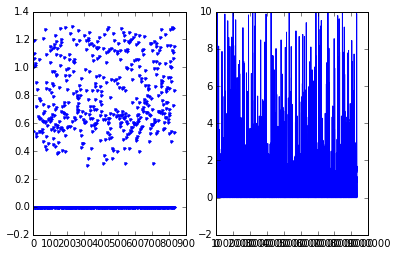

In [ ]:
subplot(1,2,1)
plot(array(LE),'.')
subplot(1,2,2)
plot(array(LE_temp)[abs(array(LE_temp))<10])

In [ ]:
mean(array(LE)[array(LE)>0])

0.78537713260017483

# leading Lyapunonv Exponent for discrete reference model
LE = 0.90064020707575143
# leading Lyapunonv Exponent for discrete reconstructed model
LE = 0.78537713260017483

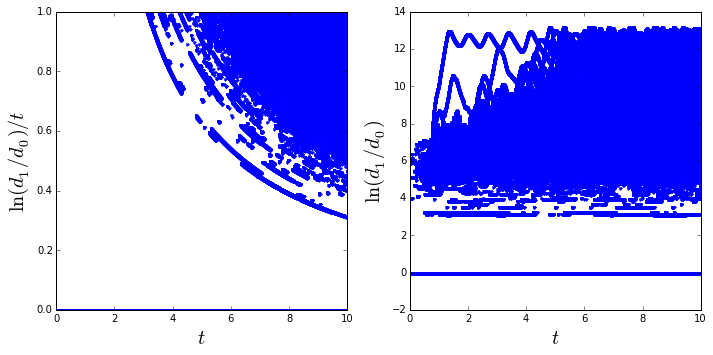

In [ ]:
figure(figsize=(10,5))
x = [t[0] for t in tsep]
y = [t[1] for t in tsep]
xs = [t[0] for t in ts]
ys = [t[1] for t in ts]
subplot(1,2,1)
plot(x,y,'.')
ylabel('$\ln(d_1/d_0)/t$',size='20')
xlabel('$t$',size='20')
#xlim(1.5,3)
ylim(0,1)
subplot(1,2,2)
plot(xs,ys,'.')
ylabel('$\ln(d_1/d_0)$',size='20')
xlabel('$t$',size='20')
tight_layout()
#xlim(1.5,3)
#ylim(0,18)

//anaconda/envs/py3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


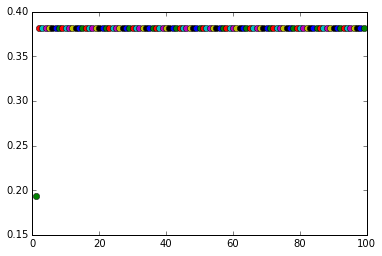

In [ ]:
for i in range(100):
    plot(i,mean(array(LE)[abs(array(LE))<i]),'o')

In [ ]:
Ll

[]

In [ ]:
t0 = 0
tend = 5.
dt = 0.01
Nt = (tend-t0)/float(dt)
time = np.linspace(t0,tend,Nt)
n = 100
t_rec0 = np.full((n,len(time),3),np.nan)
t_rec1 = np.full((n,len(time),3),np.nan)
for j in Ll:
    for i in range(1,len(time)):
        t_rec0[j,i,:] = t_rec0[j,i-1,:]+(time[1]-time[0])*Lrecder(t_rec0[1,i-1,:],1)
        t_rec1[j,i,:] = t_rec1[j,i-1,:]+(time[1]-time[0])*Lrecder(t_rec1[j,i-1,:],1)

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [ ]:
1+1

2